# Tutorial 2 (kraci)

In [1]:
import scDML
print(scDML.__version__)
import scanpy as sc 
import torch
from scDML import scDMLModel
from scDML.utils import print_dataset_information
import matplotlib.pyplot as plt
import os
import scib
import anndata as ad
os.system("clear")

###############
dataset="Lung_atlas_public"
ncluster=14
###############

data_dir="/goofys/users/Aleksandra_S/benchmarking_datasets/"+dataset+".h5ad"
adata_raw=ad.read_h5ad(data_dir)
print(adata_raw)
adata_raw.raw=adata_raw
adata_raw.obs['BATCH'] = adata_raw.obs.batch
#adata_raw.obs['celltype'] = adata_raw.obs.assigned_cluster
print_dataset_information(adata_raw,batch_key="BATCH",celltype_key="cell_type")

0.0.1


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/location' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/location' was writte

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'
===========print brief infomation of dataset ===============
===========there are 16 batchs in this dataset==============
===========there are 17 celltypes with this dataset=========


cell_type,B cell,Basal 1,Basal 2,Ciliated,Dendritic cell,Endothelium,Fibroblast,Ionocytes,Lymphatic,Macrophage,Mast cell,Neutrophil_CD14_high,Neutrophils_IL1R2,Secretory,T/NK cell,Type 1,Type 2,Total
BATCH,,,,,,,,,,,,,,,,,,
1,9,0,0,0,17,157,5,0,0,101,0,6,438,2,142,0,27,904
2,11,0,4,65,230,0,46,0,0,15,60,1227,1,3,209,0,117,1988
3,3,0,0,12,98,0,25,0,0,8,98,13,11,0,59,0,135,462
4,4,0,2,8,150,48,212,0,76,1828,0,7,0,5,4,0,1419,3763
5,23,2,1,57,182,101,139,0,68,1105,50,88,15,2,190,0,356,2379
6,2,0,0,0,495,12,51,0,0,1533,19,281,6,0,8,0,822,3229
A1,5,530,355,488,32,36,5,3,0,1,0,1,0,388,1,0,0,1845
A2,3,485,353,346,29,8,7,21,0,1,2,1,1,197,0,0,0,1454
A3,1,260,200,487,5,26,3,9,1,1,0,1,0,232,0,0,0,1226


## Raw dataset visualization

Note: ovaj dataset je normalizovan!!! <br>
Note that this dataset has the counts already separated in a layer. Here, adata.X contains log transformed scran normalized expression.

In [ ]:
#View raw data,check the batch effect of this batch effect; PODACI SU NORMALIZOVANI pa i ne mora svaki korak da se radi
adata_copy=adata_raw.copy()
sc.pp.normalize_total(adata_copy,target_sum=1e4)
sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(adata_copy,n_top_genes=2000,subset=True)
sc.pp.scale(adata_copy)
sc.tl.pca(adata_copy)
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)
sc.pl.umap(adata_copy,color=["BATCH","cell_type"],show=False)

## scDML integration

In [2]:
sc.pp.highly_variable_genes(adata_raw,n_top_genes=2000, batch_key='BATCH')

In [39]:
adata_raw.var[adata_raw.var.highly_variable].index.values.shape

(2000,)

In [40]:
adata_raw.var.index.values.shape

(15148,)

In [3]:
hvg_list = adata_raw.var[adata_raw.var.highly_variable].index.values

2023-09-11 09:28:07,766 - root - INFO - Select HVG from given highly variable genes list
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scDML/data_preprocess.py:63: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["batch"]="1"
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is

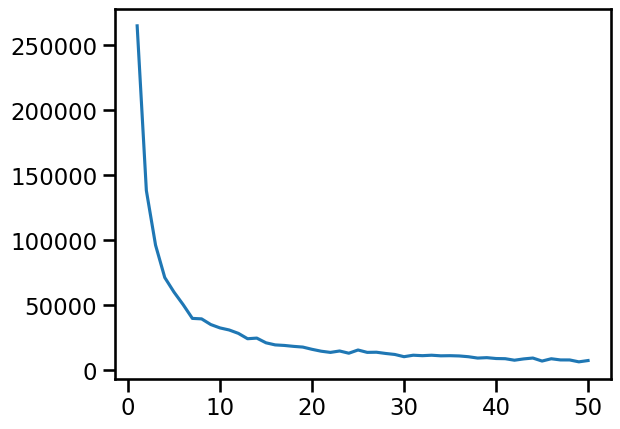

In [4]:
## fullrun
save_dir="./test_result/"+dataset+"/"

scdml=scDMLModel(verbose=False, save_dir=save_dir)
adata=scdml.preprocess(adata_raw, cluster_method="louvain", resolution=3.0, pca_dim=30, normalize_samples=False, normalize_features=False, log_normalize=False, batch_key='BATCH', hvg_list=hvg_list)
#print(adata)
scdml.integrate(adata,batch_key="BATCH",ncluster_list=[ncluster],
               expect_num_cluster=ncluster,merge_rule="rule2")

plt.plot(range(1,len(scdml.loss)+1),scdml.loss)

In [5]:
adata

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'BATCH', 'init_cluster', 'reassign_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_emb'
    varm: 'PCs'
    layers: 'counts'

## visulization of integrated embedding

... storing 'batch' as categorical
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and

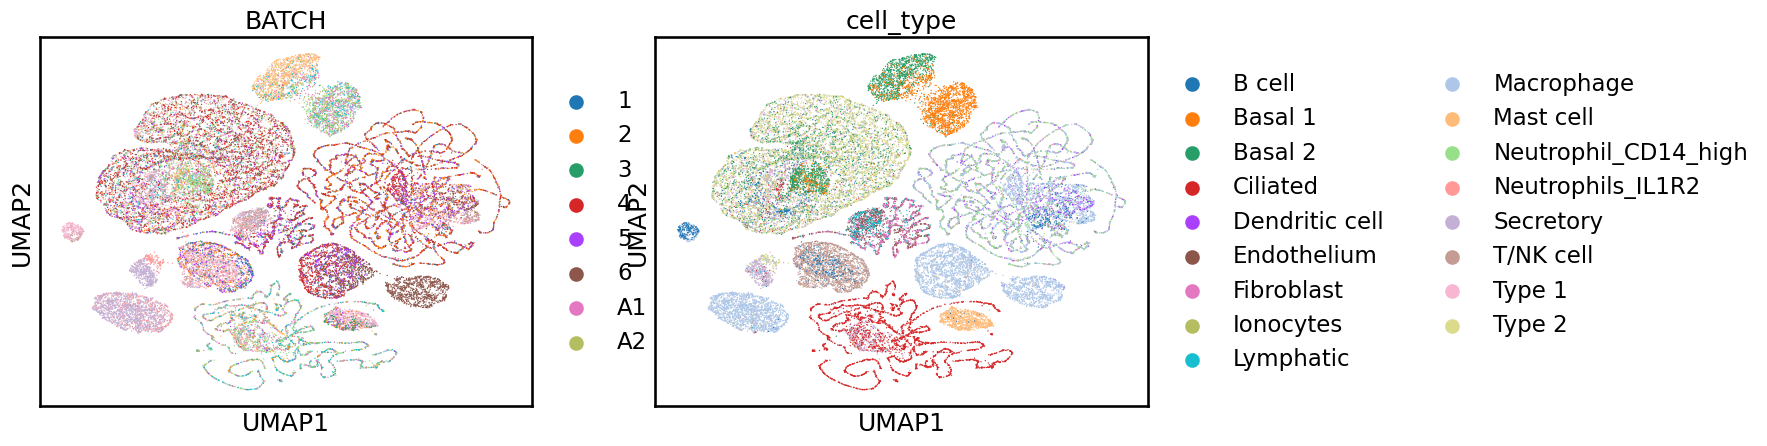

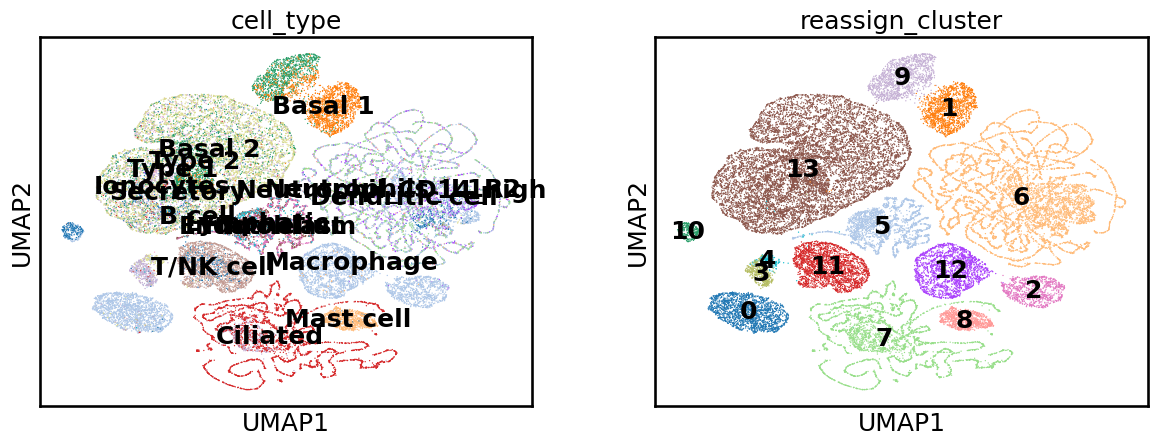

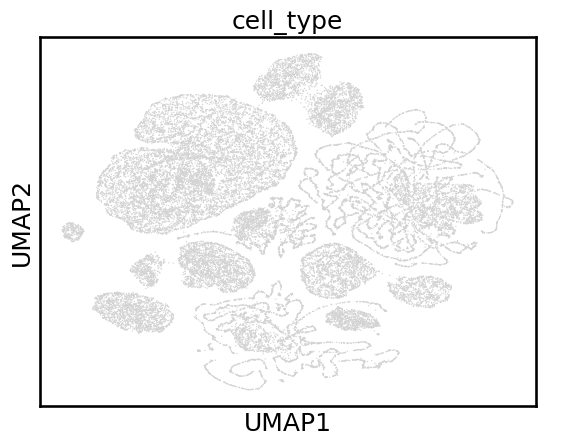

In [6]:
###########################################
sc.pp.neighbors(adata,random_state=0,use_rep="X_emb")
sc.tl.umap(adata)
###########################################

sc.pl.umap(adata,color=["BATCH", "cell_type"],show=False)
#plt.savefig(save_dir+"scDML_embedding1.png")
sc.pl.umap(adata,color=["cell_type","reassign_cluster"],legend_loc="on data",show=False)
#plt.savefig(save_dir+"scDML_embedding2.png")

sc.pl.umap(adata,color=["cell_type"],groups=["OFFx"],na_in_legend=False)

## evaluation

In [7]:
import pandas as pd
df=pd.crosstab(adata.obs["cell_type"],adata.obs["reassign_cluster"])
col=df.apply('idxmax', axis=1).values
df=df[col]
df

reassign_cluster,13,1,13,7,6,5,5,13,5,6,8,6,6,13,11,13,13
cell_type,,,,,,,,,,,,,,,,,
B cell,559,0,559,0,329,17,17,559,17,329,13,329,329,559,255,559,559
Basal 1,273,1299,273,0,0,0,0,273,0,0,0,0,0,273,0,273,273
Basal 2,2109,48,2109,1,0,0,0,2109,0,0,0,0,0,2109,0,2109,2109
Ciliated,168,0,168,2973,0,0,0,168,0,0,0,0,0,168,4,168,168
Dendritic cell,4,0,4,0,1351,0,0,4,0,1351,0,1351,1351,4,0,4,4
Endothelium,7,0,7,0,2,975,975,7,975,2,1,2,2,7,0,7,7
Fibroblast,2,0,2,0,4,723,723,2,723,4,0,4,4,2,2,2,2
Ionocytes,45,0,45,0,0,0,0,45,0,0,0,0,0,45,0,45,45
Lymphatic,4,0,4,0,0,331,331,4,331,0,0,0,0,4,2,4,4


In [8]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score
ari=adjusted_rand_score(adata.obs["reassign_cluster"],adata.obs["cell_type"])
nmi=normalized_mutual_info_score(adata.obs["reassign_cluster"],adata.obs["cell_type"])
print("ARI={}".format(ari))
print("NMI={}".format(nmi))

ARI=0.3537826026425451
NMI=0.6430970391740893


In [9]:
adata

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'BATCH', 'init_cluster', 'reassign_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'BATCH_colors', 'cell_type_colors', 'reassign_cluster_colors'
    obsm: 'X_pca', 'X_emb', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [10]:
scib.me.ilisi_graph(adata, batch_key="BATCH", type_="embed", use_rep="X_emb")

0.21939069113844187

In [11]:
# scib.me.kBET(adata, batch_key="BATCH", label_key="reassign_cluster", type_='embed', embed="X_emb")

In [12]:
# scib.me.kBET(adata, batch_key="BATCH", label_key="cell_type", type_='embed', embed="X_emb")

In [13]:
# scib.me.silhouette_batch(adata, batch_key="BATCH", embed="X_emb", metric='euclidean')

TypeError: silhouette_batch() missing 1 required positional argument: 'label_key'

In [14]:
asw = scib.me.silhouette_batch(adata, batch_key="BATCH", label_key="reassign_cluster", embed="X_emb", metric='euclidean')

mean silhouette per group:        silhouette_score
group                  
0              0.883669
1              0.926565
10             0.859684
11             0.778955
12             0.873714
13             0.791159
2              0.859715
3              0.377585
4              0.716226
5              0.821088
6              0.768460
7              0.729412
8              0.792800
9              0.726956


In [15]:
asw

0.7789990100250915

In [52]:
scib.me.silhouette_batch(adata, batch_key="BATCH", label_key="cell_type", embed="X_emb", metric='euclidean')

mean silhouette per group:                       silhouette_score
group                                 
B cell                        0.645012
Basal 1                       0.848963
Basal 2                       0.660715
Ciliated                      0.756241
Dendritic cell                0.605038
Endothelium                   0.786673
Fibroblast                    0.728593
Ionocytes                     0.670983
Lymphatic                     0.733509
Macrophage                    0.727045
Mast cell                     0.823874
Neutrophil_CD14_high          0.431615
Neutrophils_IL1R2             0.490862
Secretory                     0.477546
T/NK cell                     0.783500
Type 1                        0.917517
Type 2                        0.756840


0.6967368538992196